In [1]:
import modal
from diffusers.utils import load_image
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from PIL import ImageDraw
import cv2
from tqdm.notebook import tqdm
from typing import List, Optional, Dict, Union
from imagen_utils import *

In [2]:
inpaint_flux = modal.Function.lookup('inpaint-flux', 'inpaint_flux', environment_name='prod')
gsam = modal.Function.lookup("grounded-sam","GroundedSam.run", environment_name='prod')
#inpaint_flux = modal.Function.lookup('inpaint-flux', 'gsma_and_flux', environment_name='prod')
stable_flow = modal.Function.lookup('stable-flow', 'generate_image', environment_name='prod')

/Users/shreyas/opt/anaconda3/envs/caferacer/lib/python3.10/asyncio/events.py:80: DeprecationError: 2025-01-27: `modal.Function.lookup` is deprecated and will be removed in a future release. It can be replaced with `modal.Function.from_name`.

See https://modal.com/docs/guide/modal-1-0-migration for more information.
  self._context.run(self._callback, *self._args)
/Users/shreyas/opt/anaconda3/envs/caferacer/lib/python3.10/asyncio/events.py:80: DeprecationError: 2025-01-27: `modal.Function.lookup` is deprecated and will be removed in a future release. It can be replaced with `modal.Function.from_name`.

See https://modal.com/docs/guide/modal-1-0-migration for more information.
  self._context.run(self._callback, *self._args)
/Users/shreyas/opt/anaconda3/envs/caferacer/lib/python3.10/asyncio/events.py:80: DeprecationError: 2025-02-11: Looking up class methods using Function.from_name will be deprecated in a future version of Modal.
Use modal.Cls.from_name instead, e.g.

GroundedSam = mod

In [3]:
front_im_path = "/Users/shreyas/Downloads/episode_001_laptop.mp4"
top_im_path = "/Users/shreyas/Downloads/episode_001_phone.mp4"

In [4]:
# Load video frames
front_data = load_video_frames(front_im_path)
top_data = load_video_frames(top_im_path)
print(f"Loaded {front_data['total_frames']} frames and {top_data['total_frames']} frames")
print(f"Video duration: {front_data['duration']:.2f} seconds and {top_data['duration']:.2f} seconds")
print(f"FPS: {front_data['fps']} and {top_data['fps']}")

Loading frames:   0%|          | 0/396 [00:00<?, ?it/s]

Loading frames:   0%|          | 0/396 [00:00<?, ?it/s]

Loaded 396 frames and 396 frames
Video duration: 13.20 seconds and 13.20 seconds
FPS: 30.0 and 30.0


In [5]:
front_im = front_data["frames"][10]
top_im = top_data["frames"][10]

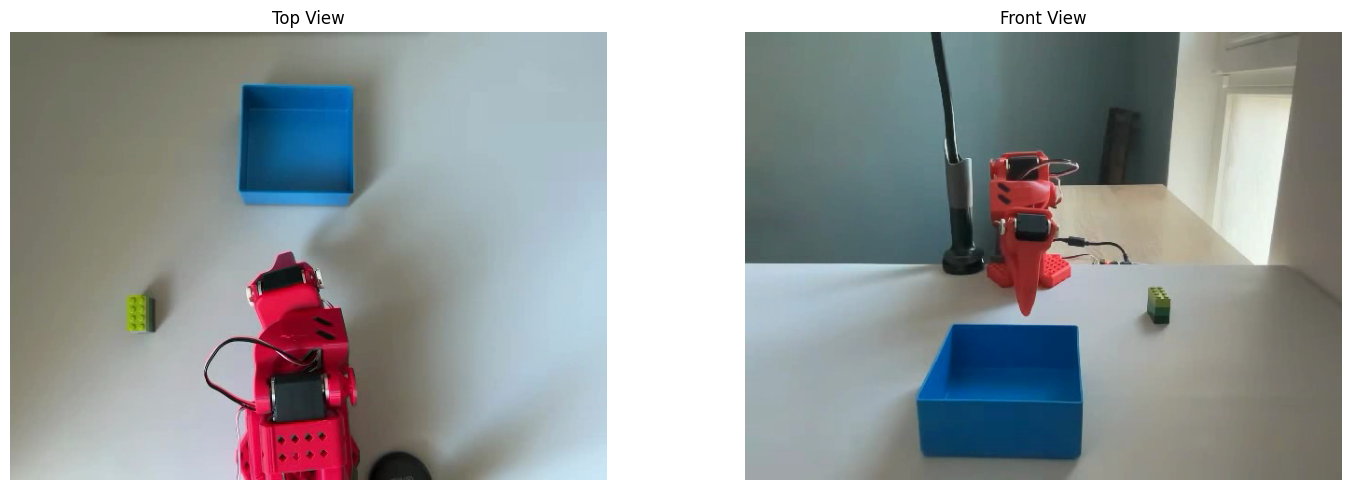

In [6]:
display_views(top_im, front_im)

In [38]:
# Resize images to 1024x1024
#front_im_big = front_im.resize((1024, 1024), Image.Resampling.LANCZOS)
#top_im_big = top_im.resize((1024, 1024), Image.Resampling.LANCZOS)


In [42]:
#front_dis = stable_flow.remote(front_im_big, prompts=["a (yellow container:1.5) on the desk with robot arm in background"])

In [7]:
front_mask, front_im_with_mask = create_inpaint_mask(front_im, "bottom-left")
top_mask, top_im_with_mask = create_inpaint_mask(top_im, "top-right")

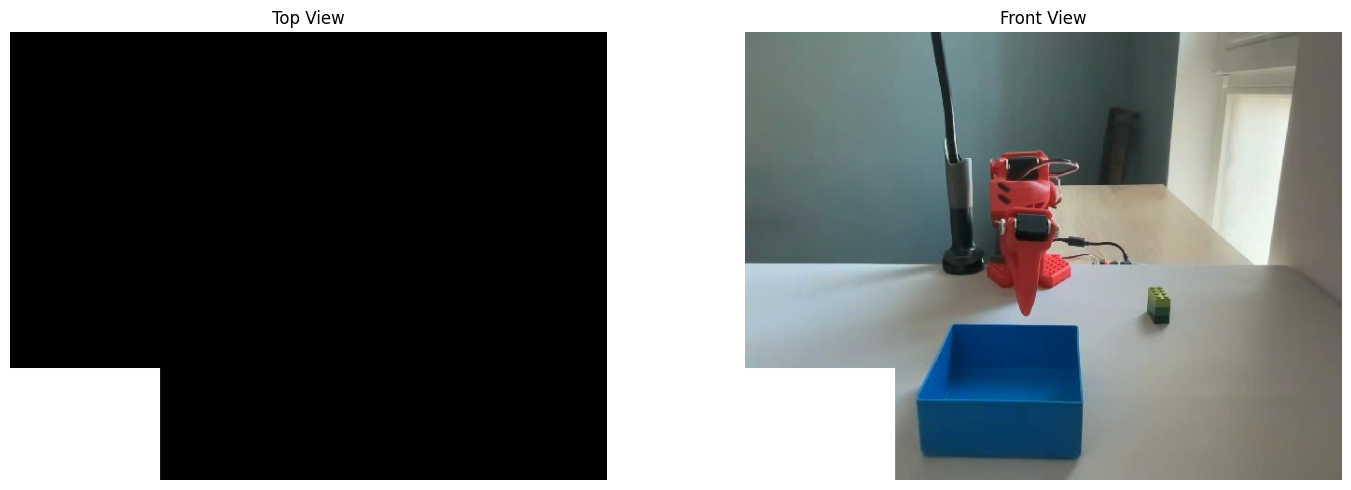

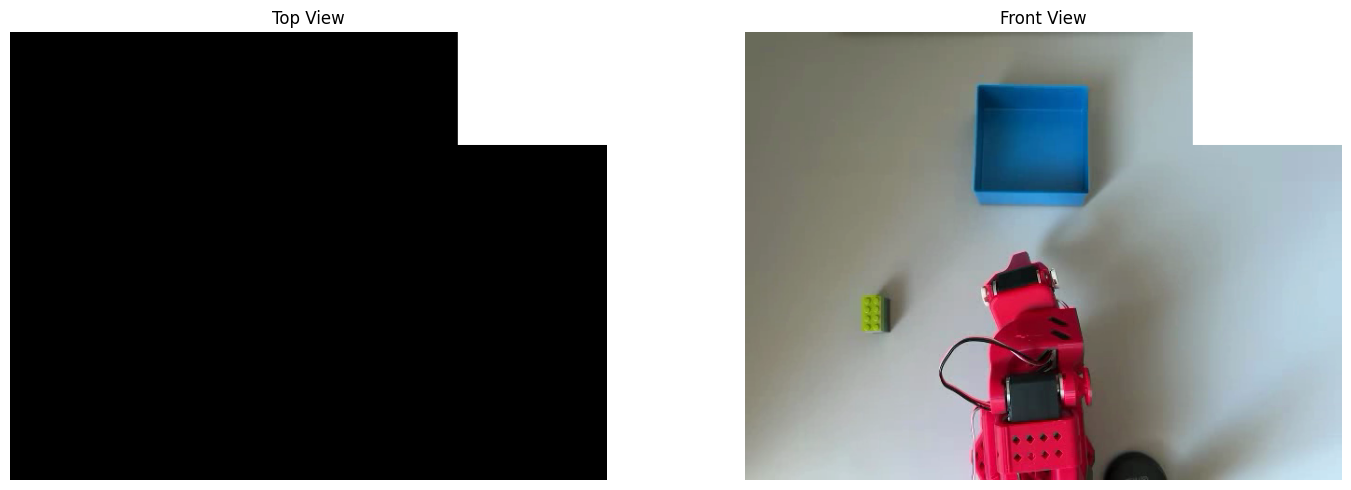

In [8]:
display_views(front_mask, front_im_with_mask)
display_views(top_mask, top_im_with_mask)



In [9]:
#new_front_im, front_mask = create_outpaint_mask(front_im, "left", plot=False)
#new_top_im, top_mask = create_outpaint_mask(top_im, "top", plot=False)

In [10]:
def inpaint_im(im, mask, prompt="", neg_prompt="artifacts, blurry, distorted", num_inference_steps=28):
    filled_image = inpaint_flux.remote(
        im,
        mask,
        prompt=prompt,
        neg_prompt=neg_prompt,
        num_inference_steps=num_inference_steps,)
    return filled_image

In [11]:
front_inpainted = inpaint_im(front_im_with_mask, front_mask, prompt="(mechanical keyboard:1.5) on desk", num_inference_steps=28)
top_inpainted = inpaint_im(top_im_with_mask, top_mask, prompt="(mechanical keyboard:1.5) on desk", num_inference_steps=28)


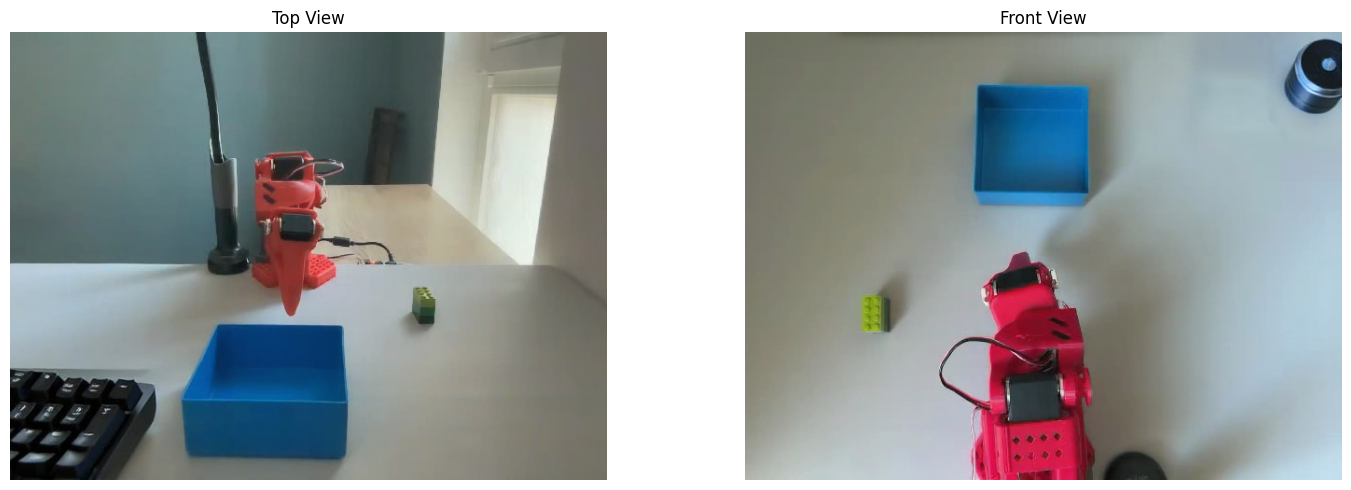

In [12]:
display_views(front_inpainted, top_inpainted)

In [ ]:
def paste_masked_region(
    target_im: Image.Image,
    original_im: Image.Image, 
    mask: Image.Image
) -> Image.Image:
    """
    Paste content from original image into target image where mask is white
    
    Args:
        target_im: Target image to paste into
        original_im: Source image to copy content from
        mask: Mask where white pixels indicate where to paste
    
    Returns:
        Image.Image: Modified target image
    """
    # Convert to PIL if needed
    if isinstance(target_im, np.ndarray):
        target_im = Image.fromarray(target_im)
    if isinstance(original_im, np.ndarray):
        original_im = Image.fromarray(original_im)
    if isinstance(mask, np.ndarray):
        mask = Image.fromarray(mask)
        
    # Create result image
    result_im = target_im.copy()
    
    # Convert mask to RGBA for alpha compositing
    mask_rgba = mask.convert('RGBA')
    mask_data = np.array(mask_rgba)
    
    # Make black regions transparent in mask
    mask_data[np.all(mask_data[:,:,:3] == 0, axis=2)] = [0,0,0,0]
    mask_data[np.all(mask_data[:,:,:3] == 255, axis=2)] = [255,255,255,255]
    alpha_mask = Image.fromarray(mask_data)
    
    # Create RGBA version of original image
    original_rgba = Image.new('RGBA', original_im.size)
    original_rgba.paste(original_im)
    
    # Paste original content using mask as alpha
    result_im.paste(original_rgba, (0,0), alpha_mask)
    
    return result_im

In [67]:
pasted_frames = []
for i in range(1, 61):
    frame = front_data["frames"][i]
    #frame = inpaint_im(frame, front_mask, prompt="(mechanical keyboard:1.5) on desk", num_inference_steps=16)
    pasted_frames.append(frame)
for i in range(61, 301):
    frame = front_data["frames"][i]
    result_im = paste_masked_region(frame, inpainted_frames[-1], front_mask)
    pasted_frames.append(result_im)

save_processed_video(pasted_frames, "/Users/shreyas/Downloads/episode_001_laptop_pasted.mp4", fps=30)

Saving video:   0%|          | 0/300 [00:00<?, ?it/s]

In [68]:
frame_f = inpainted_frames[-1]
croped_front = extract_masked_region(frame_f, front_mask)
top_wrap = create_top_view(croped_front, perspective_strength=0.3)
result_im, new_mask = paste_wrapped_image(top_im_with_mask, top_wrap, top_mask, "top-right")
top_inpainted = inpaint_im(result_im, new_mask, prompt="(mechanical keyboard:1.5) on desk", num_inference_steps=28)
   

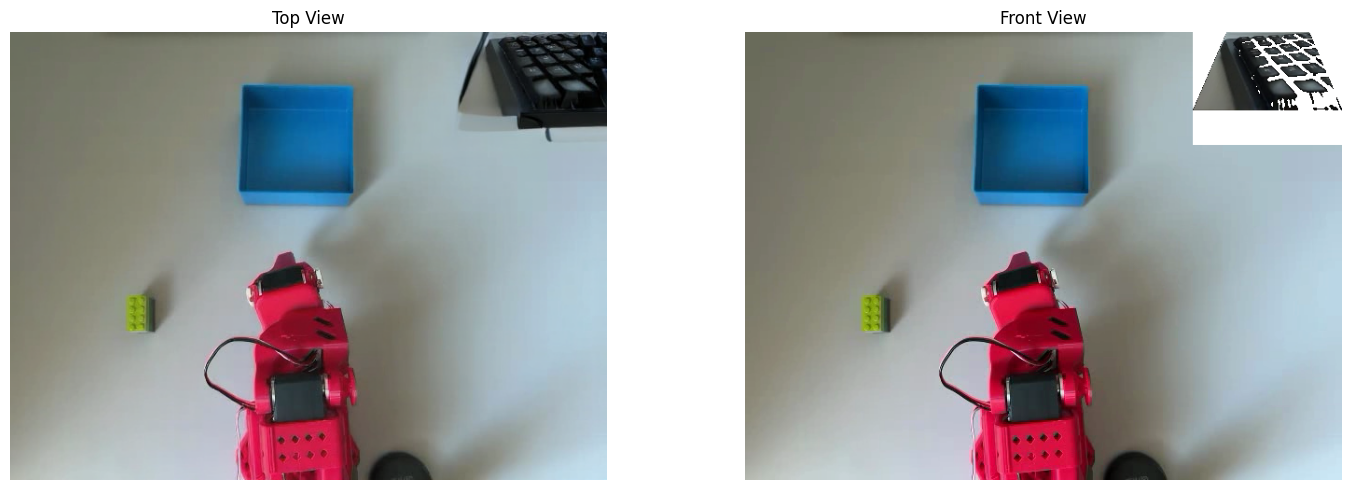

In [69]:
display_views(top_inpainted, result_im)

In [71]:
pasted_top_frames = []
for i in range(1, 61):
    frame = top_data["frames"][i]
    pasted_top_frames.append(frame)
for i in range(61, 301):
    frame = top_data["frames"][i]
    result_im = paste_masked_region(frame, top_inpainted, top_mask)
    pasted_top_frames.append(result_im)
    
save_processed_video(pasted_top_frames, "/Users/shreyas/Downloads/episode_001_phone_pasted.mp4", fps=30)


Saving video:   0%|          | 0/300 [00:00<?, ?it/s]

In [72]:
combined_frames = []
for front_frame, top_frame in zip(pasted_frames, pasted_top_frames):
    # Create a side-by-side comparison by concatenating horizontally
    combined_frame = np.hstack((front_frame, top_frame))
    combined_frames.append(combined_frame)

# Save the combined video with both views side by side    
save_processed_video(combined_frames, "/Users/shreyas/Downloads/episode_001_combined_views.mp4", fps=30)


Saving video:   0%|          | 0/300 [00:00<?, ?it/s]

In [64]:
frame_11 = front_data["frames"][100]

In [65]:
result_im = paste_masked_region(frame_11, inpainted_frames[-1], front_mask)

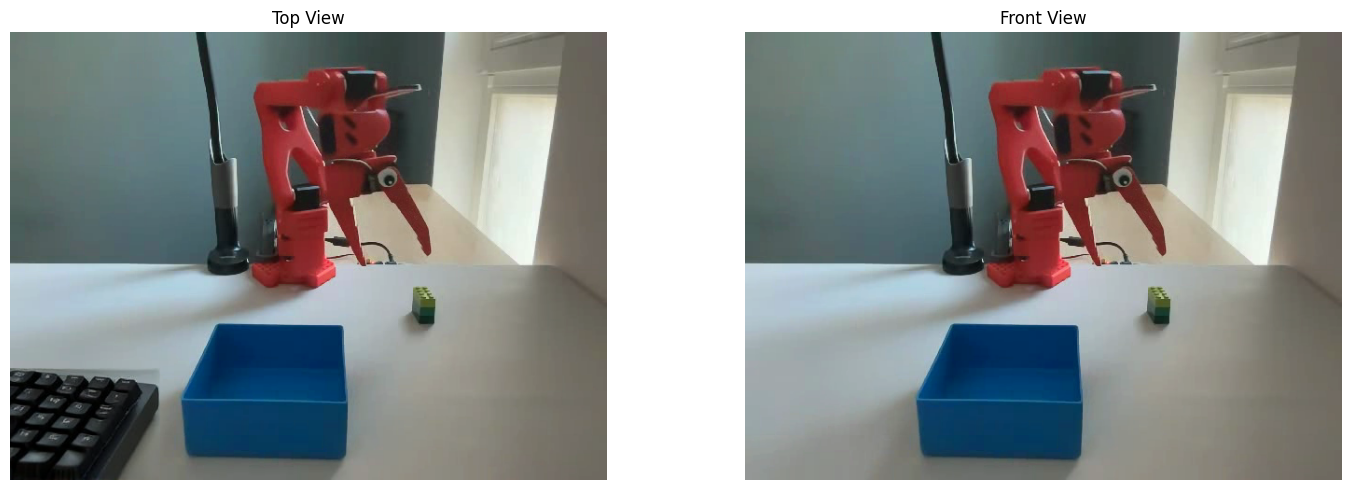

In [66]:
display_views(result_im, frame_11)

In [52]:
inpainted_frames = []
for i in range(1, 61):
    frame = front_data["frames"][i]
    #frame = inpaint_im(frame, front_mask, prompt="(mechanical keyboard:1.5) on desk", num_inference_steps=16)
    inpainted_frames.append(frame)
for i in range(61, 301):
    frame = front_data["frames"][i]
    frame = inpaint_im(frame, front_mask, prompt="(mechanical keyboard:1.5) on desk", num_inference_steps=16)
    inpainted_frames.append(frame)

save_processed_video(inpainted_frames, "/Users/shreyas/Downloads/episode_001_laptop_inpainted.mp4", fps=30)

GRPCError: (<Status.FAILED_PRECONDITION: 9>, 'Function call has expired', None)

In [73]:
import subprocess
def convert_video_for_social(
    input_path: str,
    output_path: str = None,
    platform: str = "twitter"
) -> str:
    """
    Convert video to format compatible with social media platforms
    
    Args:
        input_path: Path to input video file
        output_path: Path for output video (if None, appends _twitter to input name)
        platform: Target platform ("twitter" or "instagram")
    
    Returns:
        str: Path to converted video file
    
    Twitter specs:
    - Codec: H.264
    - Audio: AAC LC
    - Max bitrate: 25 Mbps
    - Frame rate: 60 FPS max
    - Max resolution: 1920x1200
    - Max file size: 512MB
    - Max duration: 2m 20s
    """
    if output_path is None:
        # Add _twitter before extension
        base, ext = os.path.splitext(input_path)
        output_path = f"{base}_twitter{ext}"
    
    if platform.lower() == "twitter":
        # Twitter-compatible settings
        cmd = [
            "ffmpeg", "-i", input_path,
            "-c:v", "libx264",  # H.264 codec
            "-preset", "medium",  # Encoding speed preset
            "-crf", "23",  # Quality (lower = better, 23 is default)
            "-c:a", "aac",  # AAC audio codec
            "-b:a", "128k",  # Audio bitrate
            "-pix_fmt", "yuv420p",  # Required pixel format
            "-movflags", "+faststart",  # Enable fast start for web playback
            "-y",  # Overwrite output file if exists
            output_path
        ]
    else:
        raise ValueError(f"Unsupported platform: {platform}")
        
    try:
        subprocess.run(cmd, check=True)
        return output_path
    except subprocess.CalledProcessError as e:
        raise RuntimeError(f"Error converting video: {e}")

In [75]:
# Convert video for Twitter
twitter_video = convert_video_for_social(
    "/Users/shreyas/Downloads/episode_001_combined_views.mp4",
    "/Users/shreyas/Downloads/episode_001_combined_views_twitter.mp4",
    platform="twitter"
)

ffmpeg version 5.1.2 Copyright (c) 2000-2022 the FFmpeg developers
  built with clang version 14.0.6
  configuration: --prefix=/Users/shreyas/opt/anaconda3/envs/caferacer --cc=arm64-apple-darwin20.0.0-clang --cxx=arm64-apple-darwin20.0.0-clang++ --nm=arm64-apple-darwin20.0.0-nm --ar=arm64-apple-darwin20.0.0-ar --disable-doc --disable-openssl --enable-demuxer=dash --enable-hardcoded-tables --enable-libfreetype --enable-libfontconfig --enable-libopenh264 --enable-cross-compile --arch=arm64 --target-os=darwin --cross-prefix=arm64-apple-darwin20.0.0- --host-cc=/Users/runner/miniforge3/conda-bld/ffmpeg_1674566267822/_build_env/bin/x86_64-apple-darwin13.4.0-clang --enable-neon --enable-gnutls --enable-libmp3lame --enable-libvpx --enable-pthreads --enable-gpl --enable-libx264 --enable-libx265 --enable-libaom --enable-libsvtav1 --enable-libxml2 --enable-pic --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libopus --pkg-config=/Users/runner/miniforge3/conda-bld/ffmpeg_1

In [54]:
print(len(inpainted_frames))
save_processed_video(inpainted_frames, "/Users/shreyas/Downloads/episode_001_laptop_inpainted.mp4", fps=30)

106


Saving video:   0%|          | 0/106 [00:00<?, ?it/s]

In [61]:
inpainted_top_frames = []
for i in range(1, 61):
    frame = top_data["frames"][i]
    inpainted_top_frames.append(frame)
for i in range(61, 107):
    frame = top_data["frames"][i]
    mask, im_with_mask = create_inpaint_mask(frame, "top-right")
    frame_f = inpainted_frames[i]
    croped_front = extract_masked_region(frame_f, front_mask)
    top_wrap = create_top_view(croped_front, perspective_strength=0.3)
    result_im, new_mask = paste_wrapped_image(im_with_mask, top_wrap, mask, "top-right")
    frame_inpainted = inpaint_im(result_im, new_mask, prompt="(mechanical keyboard:1.5) on desk", num_inference_steps=28)
    inpainted_top_frames.append(frame_inpainted)
    
save_processed_video(inpainted_top_frames, "/Users/shreyas/Downloads/episode_001_phone_inpainted.mp4", fps=30)



GRPCError: (<Status.FAILED_PRECONDITION: 9>, 'Function call has expired', None)

In [63]:
print(len(inpainted_top_frames))
save_processed_video(inpainted_top_frames, "/Users/shreyas/Downloads/episode_001_phone_inpainted.mp4", fps=30)

72


Saving video:   0%|          | 0/72 [00:00<?, ?it/s]

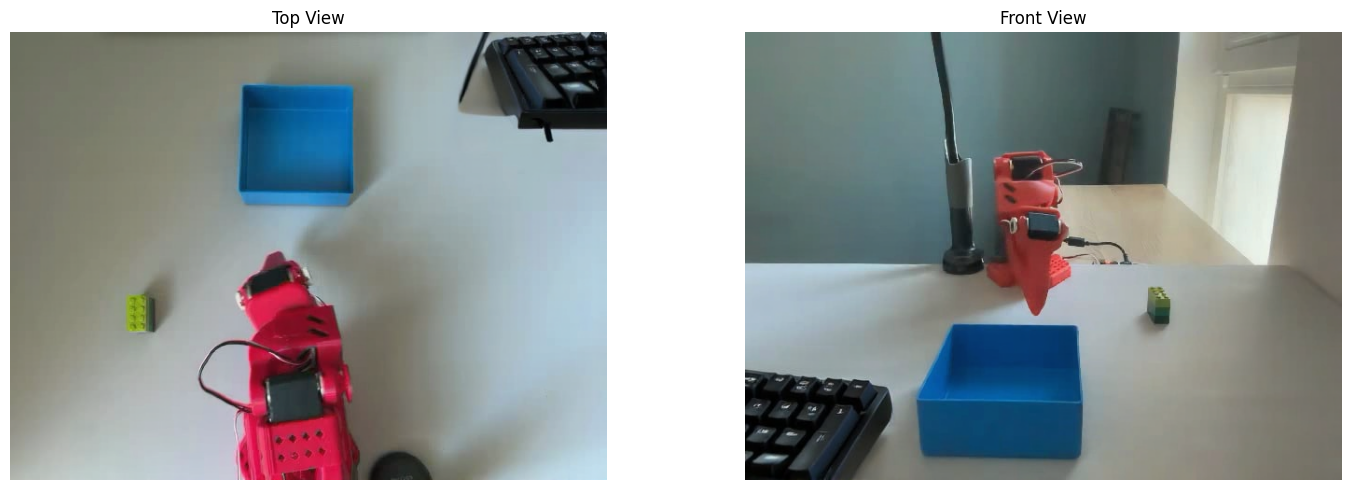

In [60]:
#display_views(inpainted_top_frames[-1], frame_f)

In [13]:
def extract_masked_region(
    im: Union[Image.Image, np.ndarray],
    mask: Image.Image
) -> Image.Image:
    """
    Extract/crop the region from image where mask is white
    
    Args:
        im: Input image (PIL Image or numpy array)
        mask: Mask image (white pixels indicate region to extract)
    
    Returns:
        Image.Image: Cropped region from original image
    """
    # Convert numpy array to PIL if needed
    if isinstance(im, np.ndarray):
        im = Image.fromarray(im)
    
    # Convert mask to numpy array
    mask_arr = np.array(mask)
    
    # Find white pixels (assuming RGB mask where white is [255,255,255])
    white_pixels = np.all(mask_arr == 255, axis=2)
    white_coords = np.where(white_pixels)
    
    # Get bounding box of white region
    min_y, max_y = white_coords[0].min(), white_coords[0].max()
    min_x, max_x = white_coords[1].min(), white_coords[1].max()
    
    # Crop original image to this region
    cropped_region = im.crop((min_x, min_y, max_x + 1, max_y + 1))
    
    return cropped_region

In [14]:
croped_front = extract_masked_region(front_inpainted, front_mask)

In [15]:
def create_top_view(
    im: Union[Image.Image, np.ndarray],
    rotation_angle: float = 0.0,
    perspective_strength: float = 0.3
) -> Image.Image:
    """
    Rotate image and apply perspective transform to simulate top view
    
    Args:
        im: Input image (PIL Image or numpy array)
        rotation_angle: Rotation angle in degrees
        perspective_strength: Strength of perspective transform (0 to 1)
    
    Returns:
        Image.Image: Transformed image
    """
    # Convert numpy array to PIL if needed
    if isinstance(im, np.ndarray):
        im = Image.fromarray(im)
    
    # Get image dimensions
    width, height = im.size
    
    # First rotate the image
    rotated_im = im.rotate(rotation_angle, expand=True, resample=Image.BICUBIC)
    # Flip the image horizontally
    rotated_im = rotated_im.transpose(Image.FLIP_LEFT_RIGHT)
    
    # Calculate perspective transform points
    # Source points (corners of original image)
    src_points = np.float32([
        [0, 0],  # top-left
        [width, 0],  # top-right
        [width, height],  # bottom-right
        [0, height]  # bottom-left
    ])
    
    # Calculate destination points for perspective transform
    perspective_shift = int(height * perspective_strength)
    dst_points = np.float32([
        [perspective_shift, perspective_shift],  # top-left moved down and right
        [width - perspective_shift, perspective_shift],  # top-right moved down and left
        [width, height],  # bottom-right stays
        [0, height]  # bottom-left stays
    ])
    
    # Calculate perspective transform matrix
    matrix = cv2.getPerspectiveTransform(src_points, dst_points)
    
    # Apply perspective transform
    rotated_arr = np.array(rotated_im)
    result_arr = cv2.warpPerspective(
        rotated_arr,
        matrix,
        (width, height),
        flags=cv2.INTER_LINEAR
    )
    
    # Convert back to PIL Image
    result_im = Image.fromarray(result_arr)
    
    return result_im

In [16]:
top_wrap = create_top_view(croped_front, perspective_strength=0.3)

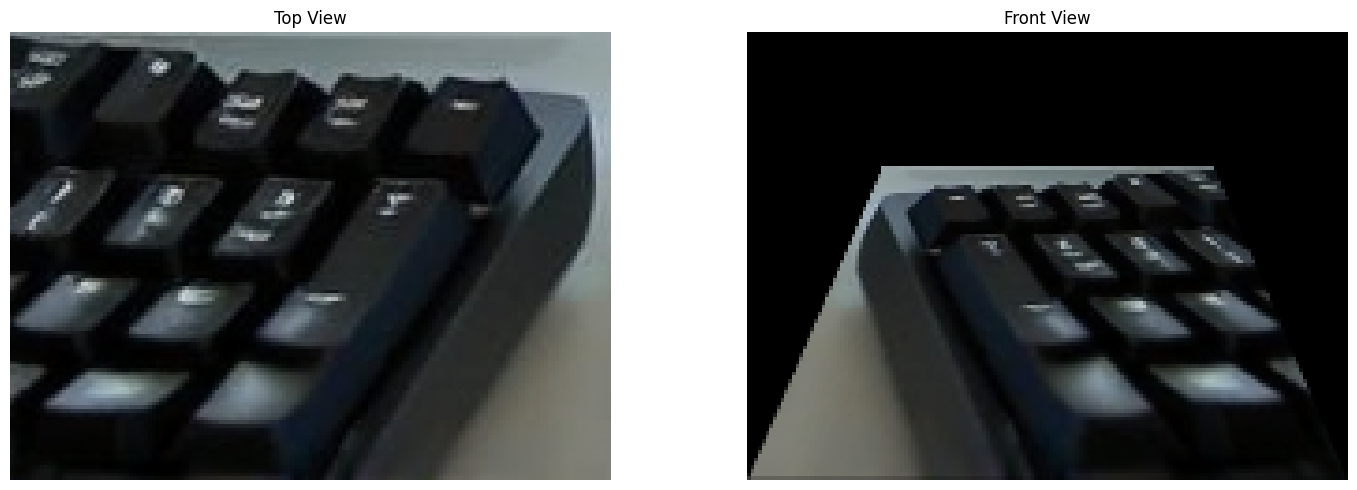

In [17]:
display_views(croped_front, top_wrap)

In [38]:
result_im, new_mask = paste_wrapped_image(top_im_with_mask, top_wrap, top_mask, "top-right")

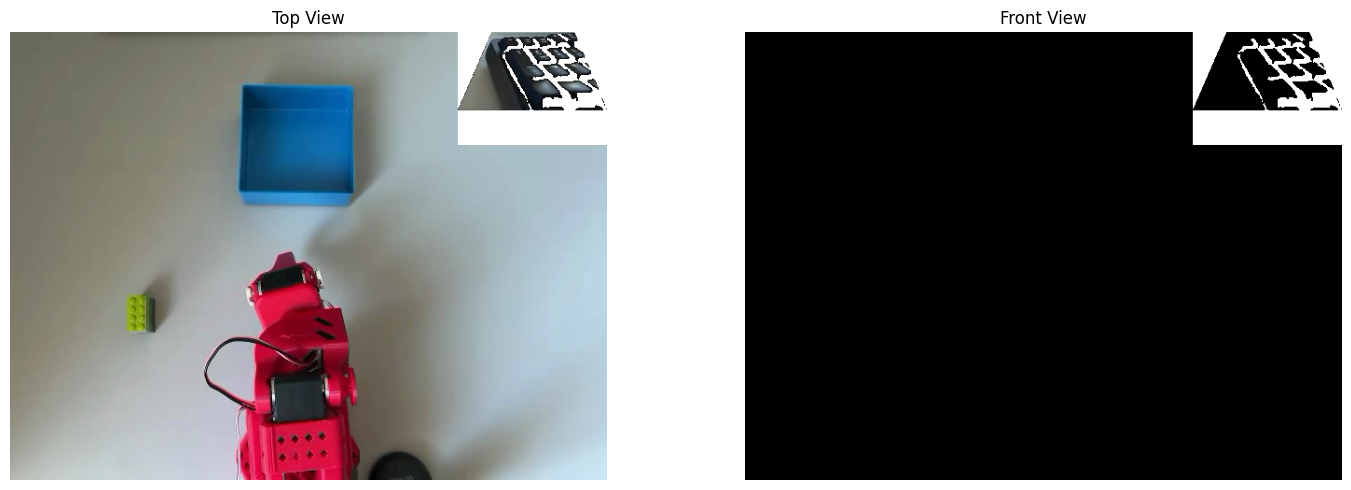

In [39]:
display_views(result_im, new_mask)

In [40]:
top_inpainted = inpaint_im(result_im, new_mask, prompt="(mechanical keyboard:1.5) on desk", num_inference_steps=28)


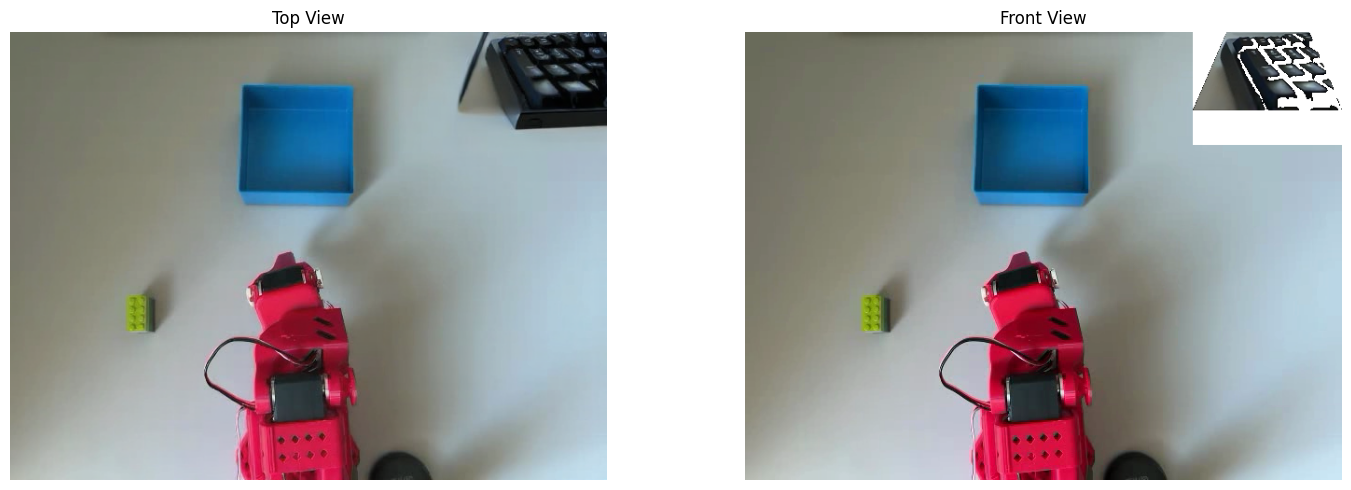

In [41]:
display_views(top_inpainted, result_im)

In [10]:
frame11 = front_data["frames"][300]
frame11.show()

In [ ]:
processed_frames = process_video_with_single_inpaint(
    inpaint_flux,
    front_im_path,  # or frames_data dictionary
    direction="left",
    prompt="grey desk and wall in background",
    blend_width=30,
    output_path="/Users/shreyas/Downloads/episode_001_laptop_processed_video1.mp4"
)